In [ ]:
#|default_exp training

In [ ]:
#|export
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import matplotlib.pyplot as plt
from torch import nn, tensor
import torch.nn.functional as F
from pathlib import Path

In [ ]:
from fastcore.test import test_close
import deeplake
from sklearn.model_selection import train_test_split
from collections import Counter
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

ds = deeplake.load('hub://activeloop/not-mnist-small', read_only=True, verbose=False)

images = ds.tensors['images'].numpy().reshape(-1, 784).astype('float32')
labels = ds.tensors['labels'].numpy().squeeze(-1).astype('int')

x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.2, random_state=1)
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train, x_valid = x_train/255., x_valid/255.

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.18) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


# Initial Setup

## Data

In [ ]:
#|export
def char(y): return 'ABCDEFGHIJ'[y]

In [ ]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([14979, 10])

## Cross entropy loss

First, we need to compute the softmax of out activations. This is defined by:
    
$$ \text{Softmax}(x)_i = \frac{e^{x_i}}{e^{x_1} + e^{x_2} + \ldots + e^{x_N}}, \quad \text{for } i = 1, 2, \ldots, N $$


or more concisely, 

$$ \text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}} $$
    
In practice, we will need the log of the softmax 



In [ ]:
def log_softmax(x): return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [ ]:
log_softmax(pred)

tensor([[-2.34, -2.22, -2.05,  ..., -2.41, -2.57, -2.15],
        [-2.37, -2.37, -2.03,  ..., -2.52, -2.53, -2.33],
        [-2.45, -2.24, -2.15,  ..., -2.43, -2.51, -2.23],
        ...,
        [-2.39, -2.35, -2.02,  ..., -2.39, -2.54, -2.33],
        [-2.53, -2.31, -2.09,  ..., -2.52, -2.51, -2.17],
        [-2.38, -2.31, -2.26,  ..., -2.38, -2.42, -2.21]], grad_fn=<LogBackward0>)

Note that the formula

$$ \log_{b}\left(\frac{a}{c}\right) = \log_{b}(a) - \log_{b}(c) $$

gives a simplification when we compute the log softmax.

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula

$$ \log\left(\sum_{i=1}^{n} e^{x_i}\right) = a + \log\left(\sum_{i=1}^{n} e^{x_i - a}\right) $$

where a is the maximum of the $x_i$

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [ ]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.34, -2.22, -2.05,  ..., -2.41, -2.57, -2.15],
        [-2.37, -2.37, -2.03,  ..., -2.52, -2.53, -2.33],
        [-2.45, -2.24, -2.15,  ..., -2.43, -2.51, -2.23],
        ...,
        [-2.39, -2.35, -2.02,  ..., -2.39, -2.54, -2.33],
        [-2.53, -2.31, -2.09,  ..., -2.52, -2.51, -2.17],
        [-2.38, -2.31, -2.26,  ..., -2.38, -2.42, -2.21]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
    $$-\sum_{i=1}^{N} y_i \cdot \log(\hat{y}_i)$$
But since out $xs$ are 1-hot encoded, this can be written as $-log(p_i)$ where $i$ is the index of the desired target

This can be done using numpy-style integer array indexing. Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [ ]:
y_train[:3]

tensor([8, 5, 2])

In [ ]:
sm_pred[0, 5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.40, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.26, grad_fn=<SelectBackward0>))

In [ ]:
sm_pred[[0, 1, 2], y_train[:3]]

tensor([-2.57, -2.50, -2.15], grad_fn=<IndexBackward0>)

In [ ]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.31, grad_fn=<NegBackward0>)

Then use PyTorch's implementation

In [ ]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`

In [ ]:
test_close(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:

    - get the output of the model on a batch of inputs
    - compare the output to the labels we have and compute a loss
    - calculate the gradients of the loss with repsect to every parameter of the model
    - update said parameters with those gradients to make them a little bit better

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.02,  0.14,  0.32, -0.03,  0.07, -0.03,  0.07, -0.04, -0.21,  0.21], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [ ]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [ ]:
torch.argmax(preds, dim=-1)

tensor([2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 9, 5, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 4, 2, 2, 1,
        2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 9, 9, 2, 2, 2])

In [ ]:
#|export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.16)

In [ ]:
lr = 0.1 # learning rate
epochs = 3 # how many epochs to train for

In [ ]:
#|export
def report(loss, preds, yb): print(f'{loss: .2f}, {accuracy(preds, yb): .2f}')

In [ ]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

 2.32,  0.16


In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i + bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

 0.63,  1.00
 0.42,  1.00
 0.31,  1.00


## Using parameters and optim

### Parameters

In [ ]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
m1.named_children()

<generator object Module.named_children>

In [ ]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.24, -0.11,  0.46],
         [-0.17, -0.46, -0.07],
         [-0.29,  0.31,  0.08],
         [-0.24,  0.13, -0.17]], requires_grad=True),
 Parameter containing:
 tensor([ 0.01,  0.51, -0.11, -0.47], requires_grad=True)]

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [ ]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
loss_func = F.cross_entropy

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()

 0.62,  1.00
 0.40,  1.00
 0.29,  1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that submodules you define are properly registerd as parameters of the model

In [ ]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            # for p in l.parameters(): yield p
            yield from l.parameters()

In [ ]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
class MyModule:
    def __init__(self):
        self._modules = {}
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self): return f'{self._modules}'
    
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x): raise Exception("Not implemented")
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [ ]:
class Model(MyModule):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [ ]:
model = Model(m, nh, 10)

In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
model(xb).shape

torch.Size([3, 10])

### Registering modules

In [ ]:
from functools import reduce

In [ ]:
reduce(lambda x, y: x + y, [1, 2, 3, 4, 5], 100)

115

We can use the original `layers` approach, but we have to register the modules.

In [ ]:
nn.Linear(nh, 10)

Linear(in_features=50, out_features=10, bias=True)

In [ ]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [ ]:
def neg(x): return -x
def exp(x): return np.exp(x)
def log(x): return np.log(x)

In [ ]:
reduce(lambda x, y: y(x), [neg, exp, log, neg], 100)

100.0

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([3, 10])

## nn.ModuleList

`nn.ModuleList` does this for us

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

 0.66,  1.00
 0.43,  1.00
 0.33,  1.00


In [ ]:
accuracy(model(x_train), y_train), accuracy(model(x_valid), y_valid)

(tensor(0.91), tensor(0.90))

## nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [ ]:
model = nn.Sequential(nn.Linear(784, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
fit()

 0.73,  0.67
 0.53,  1.00
 0.39,  1.00


In [ ]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.25, grad_fn=<NllLossBackward0>), tensor(1.))

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [ ]:
class Optimizer:
    def __init__(self, params, lr=0.5): 
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
    for i in range(0, x_train.shape[0], bs):
        s = slice(i, i + bs)
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

 2.20,  0.33
 1.46,  0.67
 0.84,  0.67


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stiff like momentum, which we'll look at later)

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.42, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, x_train.shape[0], bs):
        s = slice(i, i + bs)
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

 0.65,  1.00
 0.38,  1.00
 0.25,  1.00


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values seperately:

    xb = x_train[s]
    yb = y_train[s]

Instead, lets do these two steps together by introducing a `Dataset` class:
    
    xb,yb = train_ds[s]

In [ ]:
#|export
class Dataset:
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [ ]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28 * 28)
assert yb.shape == (5,)
xb, yb

(tensor([[1.00, 1.00, 1.00,  ..., 1.00, 1.00, 1.00],
         [0.85, 1.00, 1.00,  ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.43, 1.00, 0.99,  ..., 0.00, 0.00, 0.00]]),
 tensor([8, 5, 2, 6, 5]))

In [ ]:
for epoch in range(epochs):
    for i in range(0, len(train_ds), bs):
        xb, yb = train_ds[i: i + bs]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

 0.19,  1.00
 0.14,  1.00
 0.12,  1.00


## DataLoader

Previously, our loop iterated over batches (xb, yb) like this:
    
    for i in range(0, n, bs):
        xb, yb = train_ds[i: i + bs]
        ...
    
Let's make out loop much cleaner, using a data loader:
    
    for xb, yb in train_dl:
        ...

In [ ]:
class DataLoader:
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i: i + self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [ ]:
yb

tensor([6, 5, 0, 0, 9, 9, 7, 4, 4, 6, 2, 4, 7, 5, 8, 3, 1, 9, 0, 3, 1, 0, 1, 3, 3, 2, 2, 0, 5, 2, 7, 5, 1, 2, 1, 8, 1, 2, 7,
        6, 1, 2, 5, 9, 4, 1, 9, 0, 2, 6, 7, 9, 7, 0, 1, 0, 3, 3, 7, 5, 9, 5, 0, 2])

'H'

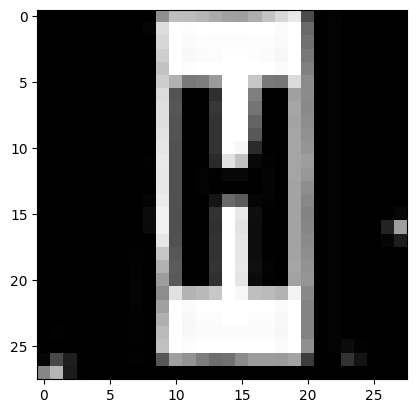

In [ ]:
plt.imshow(xb[6].view(28, 28))
char(yb[6])

In [ ]:
model, opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()

 0.70,  1.00
 0.45,  1.00
 0.31,  1.00


### Random Sampling

We want our training set to be in random order, and that order should differ each iteration. But the validation set should not be randomized

In [ ]:
import random

In [ ]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [ ]:
from itertools import islice

In [ ]:
ss = Sampler(train_ds)

In [ ]:
it = iter(ss)
for _ in range(5): print(next(it))

0
1
2
3
4


In [ ]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [ ]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[6243, 6451, 7888, 2292, 8679]

In [ ]:
import fastcore.all as fc

In [ ]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batchs = BatchSampler(ss, 4)

In [ ]:
it = iter(batchs)
next(it)

[13386, 2469, 8504, 10104]

In [ ]:
list(islice(batchs, 5))

[[4734, 6530, 8349, 1465],
 [6935, 10705, 9002, 14164],
 [13897, 14864, 8347, 8576],
 [14623, 8052, 12372, 13652],
 [6247, 5697, 9023, 10904]]

In [ ]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batchs=valid_samp, collate_fn=collate)

In [ ]:
xb, yb = next(iter(train_dl))

'E'

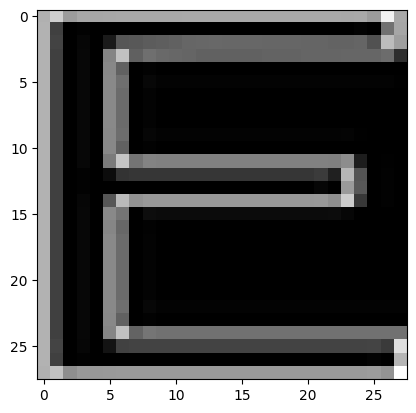

In [ ]:
plt.imshow(xb[0].view(28, 28))
char(yb[0])

## Multiprocessing DataLoader

In [ ]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [ ]:
train_ds[[3, 6, 8, 1]]

(tensor([[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.25, 0.63, 0.99,  ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.85, 1.00, 1.00,  ..., 0.00, 0.00, 0.00]]),
 tensor([6, 3, 4, 5]))

In [ ]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.25, 0.63, 0.99,  ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
         [0.85, 1.00, 1.00,  ..., 0.00, 0.00, 0.00]]),
 tensor([6, 3, 4, 5]))

In [ ]:
for o in map(train_ds.__getitem__, ([3, 6], [8, 1])): print(o)

(tensor([[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.25, 0.63, 0.99,  ..., 0.00, 0.00, 0.00]]), tensor([6, 3]))
(tensor([[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.85, 1.00, 1.00,  ..., 0.00, 0.00, 0.00]]), tensor([4, 5]))


In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, self.batchs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)

In [ ]:
it = iter(train_dl)
xb, yb= next(it)
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

## Pytorch DataLoader

In [ ]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

 0.07,  1.00
 1.15,  0.67
 2.95,  0.33


(tensor(0.91, grad_fn=<NllLossBackward0>), tensor(0.73))

PyTorch can auto-generate the BatchSampler for us:

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

PyTorch can also generate the Sequential/RandomSamplers too:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
model, opt = get_model()
fit()

loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

 0.08,  1.00
 0.15,  1.00
 0.07,  1.00


(tensor(0.34, grad_fn=<NllLossBackward0>), tensor(0.90))

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

## Validation

You always should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.4708721767280385 0.8777036050133139
1 0.6877785293377926 0.7898531377076784
2 0.41901151605537323 0.8726301737875741
3 0.36406891479670445 0.900400534268215
4 0.34689619346995537 0.9025367158436489


## Export

In [ ]:
from nbdev import nbdev_export; nbdev_export()